In [1]:
from __future__ import absolute_import, division

import os
import urllib, cStringIO

import pymongo as pm

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/judithfan/graphical_conventions/analysis/python/analysis_helpers.pyc'>

### setup

In [42]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions_recog']

# which iteration name should we use?
iterationName = 'pilot1'

### get basic participation stats

In [43]:
## list of researchers
researchers = ['A4SSYO0HDVD4E', 'A1BOIDKD33QSDK']
num_correct_thresh = 0

## get list of valid sessions with reasonable accuracy
workers = coll.find({ '$and': [{'iterationName':iterationName}]}).distinct('workerId')
workers = [i for i in workers if len(i)>10 and i not in researchers] ## filter workers
print '{} workers performed this task'.format(len(workers))

202 workers performed this task


In [44]:
## get total number of recog events in the collection as a whole
top_workers = []
for i,w in enumerate(workers):
    print 'Analyzing {} | {} of {}'.format(w,str(i).zfill(3),len(workers))
    clear_output(wait=True)
    R = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w}]}).sort('time',-1)
    num_correct = np.sum([r['correct'] for r in R])
    if num_correct >= num_correct_thresh:
        top_workers.append(w)
        
print '{} workers got at least {} correct.'.format(len(top_workers),num_correct_thresh)        

202 workers got at least 0 correct.


### construct group dataframe

In [45]:
## get total number of recog events in the collection as a whole
# grab rep & accuracy
rep = []
correct = []
rt = []
condition = []
orig_correct = []
generalization = []
target = []
distractor1 = []
distractor2 = []
distractor3 = []
orig_gameID = []
gameID = []
for i,w in enumerate(top_workers):
    print 'Now analyzing {} | {} of {}'.format(w,str(i+1).zfill(3), len(top_workers))
    clear_output(wait=True)
    R = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w}]}).sort('time')
    for r in R:
        rep.append(r['repetition'])
        correct.append(r['correct'])
        rt.append(r['rt'])
        condition.append(r['condition'])
        if 'outcome' in r.keys():
            orig_correct.append(r['outcome'])
        else:
            orig_correct.append(r['original_correct'])
        generalization.append(r['Generalization'])
        target.append(r['target'])
        distractor1.append(r['distractor1'])
        distractor2.append(r['distractor2'])
        distractor3.append(r['distractor3'])
        orig_gameID.append(r['sketch'].split('_')[0])
        gameID.append(r['gameID'])
    
## make dataframe
X = pd.DataFrame([rep,correct,rt,condition,orig_correct,\
                 generalization,target,distractor1,distractor2,\
                 distractor3,orig_gameID,gameID])
X = X.transpose()
X.columns = ['repetition','correct','rt','condition', 'orig_correct',\
             'generalization','target','distractor1','distractor2',\
             'distractor3','orig_gameID','gameID']

## convert datatypes to numeric
X['correct'] = pd.to_numeric(X['correct'])
X['rt'] = pd.to_numeric(X['rt'])
X['orig_correct'] = pd.to_numeric(X['orig_correct'])
    
print 'Finished analyzing top workers.'
print 'There are {} observation in the dataframe.'.format(X.shape[0])

Finished analyzing top workers.
There are 2012 observation in the dataframe.


#### preprocessing helper 

In [46]:
## function to unroll target, distractor dicts into separate columns
def dict2cols(X,item='target'):
    '''
    X = dataframe containing group data
    item = which item column to unroll: target? distractor1? 
    '''
    df = pd.DataFrame.from_dict(X[item]) ## make temporary dataframe with dictionary as main column
    df2 = df[item].apply(pd.Series) ## separate into different columns
    ## rename to ensure uniqueness
    df3 = df2.rename(columns={'objectname': '{}_objectname'.format(item),\
                              'shapenetid': '{}_shapenetid'.format(item),\
                              'url': '{}_url'.format(item)})
    X2 = X.join(df3) ## add to original group dataframe
    X2.drop(labels=[item],axis=1,inplace=True) ## remove old dictionary column
    return X2

## now actually apply unrolling function
items = ['target','distractor1','distractor2','distractor3']
for item in items: 
    print 'Unrolling {}'.format(item)
    clear_output(wait=True)
    if item in X.columns:
        X = dict2cols(X,item=item)
        
print 'Finished unrolling item dictionaries into separate columns.'

Finished unrolling item dictionaries into separate columns.


In [47]:
## view recognizability by repetition in tabular form
X.groupby(['condition','repetition'])['correct'].mean()

condition  repetition
control    0             0.577114
           1             0.641791
repeated   0             0.611940
           1             0.661692
           2             0.651741
           3             0.676617
           4             0.547264
           5             0.658416
           6             0.616915
           7             0.683168
Name: correct, dtype: float64

### visualize recognizability x repetition

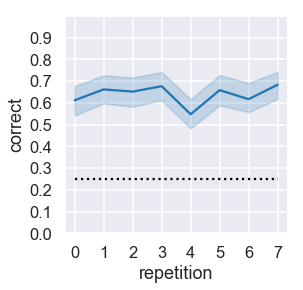

<Figure size 1152x1152 with 0 Axes>

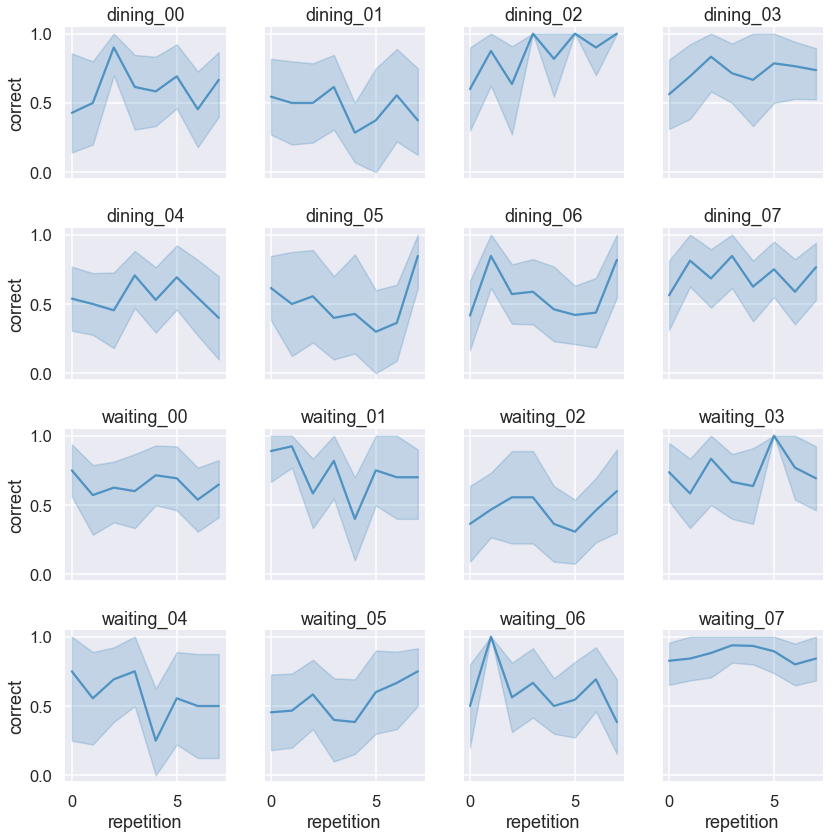

In [121]:
## get dataframe subsetted by condition and broken out by target
X2 = X[X['condition']=='repeated'].reset_index(drop=True)
X2 = X2.sort_values(by=['target_objectname'])
targ_list = np.unique(X2.target_objectname.values)
sns.set_context('talk')

## plot recognizxability, collapsing across target
fig = plt.figure(figsize=(4,4))
sns.lineplot(data=X2,x='repetition',y='correct')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, 8, 1))
plt.plot([0,7],[0.25,0.25],color='black',linestyle=':')

## plot recognizability, split out by target
fig = plt.figure(figsize=(16,16))
g = sns.FacetGrid(X2, col="target_objectname", col_wrap=4,height=3, margin_titles=False)
g.map(sns.lineplot, "repetition", "correct", alpha=.7)
g.set_titles("{col_name}")
plt.tight_layout()

### aggregate with original refgame dataset and compare

In [124]:
## load in original group_data
path_to_group_data = os.path.join(results_dir,'graphical_conventions.csv')
O = pd.read_csv(path_to_group_data)

In [130]:
## aggregate original refgame and recog dataframes
OR = O[O['condition']=='repeated'].reset_index(drop=True)
OR = OR.rename(columns={'outcome':'correct'})
OR['expID'] = pd.Series(['refgame']*len(OR))
X2['expID'] = pd.Series(['recog']*len(X2))
## concatenated original and recog experiments
R = pd.concat([OR,X2],axis=0,sort=False)

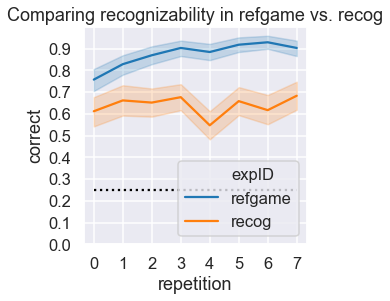

In [137]:
fig = plt.figure(figsize=(4,4))
sns.lineplot(data=R,x='repetition',y='correct',hue='expID')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, 8, 1))
plt.plot([0,7],[0.25,0.25],color='black',linestyle=':')
plt.legend(loc = 'lower right')
t = plt.title('Comparing recognizability in refgame vs. recog')

### visualize rt x repetition

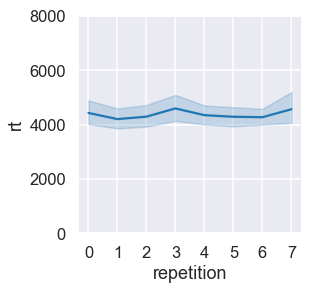

<Figure size 1152x1152 with 0 Axes>

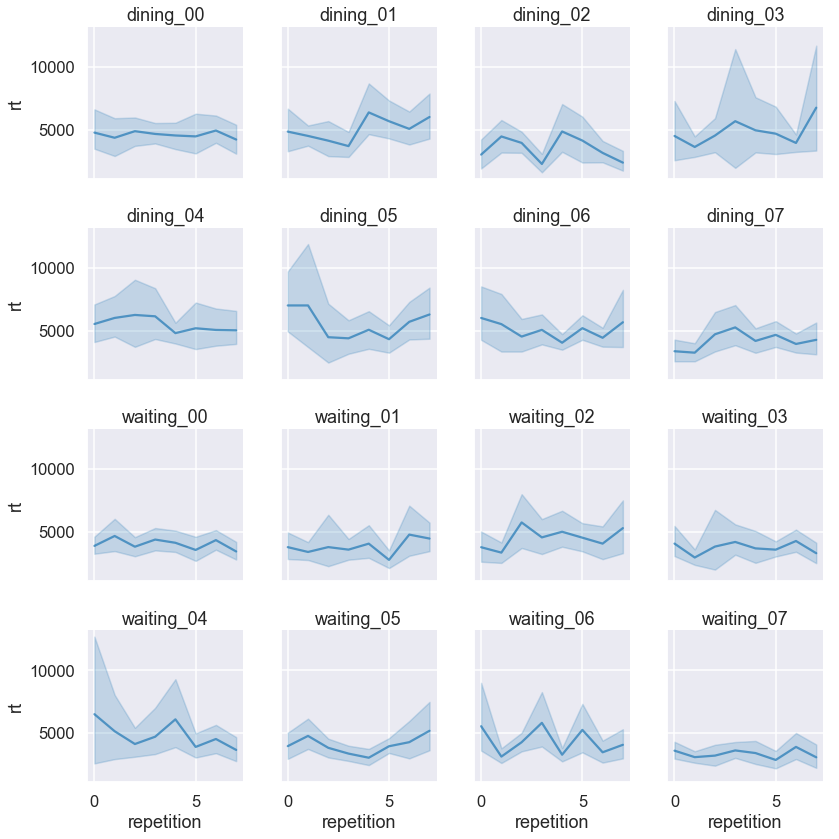

In [10]:
## get dataframe subsetted by condition and broken out by target
X2 = X.query("condition=='repeated'")
X2 = X2.sort_values(by=['target_objectname'])
targ_list = np.unique(X2.target_objectname.values)
sns.set_context('talk')

## plot rt, collapsing across target
fig = plt.figure(figsize=(4,4))
sns.lineplot(data=X2,x='repetition',y='rt')
plt.ylim(0,1)
plt.yticks(np.arange(0, 10000, 2000))
plt.xticks(np.arange(0, 8, 1))

## plot rt, split out by target
fig = plt.figure(figsize=(16,16))
g = sns.FacetGrid(X2, col="target_objectname", col_wrap=4,height=3, margin_titles=False)
g.map(sns.lineplot, "repetition", "rt", alpha=.7)
g.set_titles("{col_name}")
plt.tight_layout()

### compute BIS (z-score within original gameID)

In [11]:
def zscore(x,mu,sd):
    return (x-mu)/(sd+1e-6)

In [12]:
## sort dataframe by original gameID, repetition, and target_objectname
X3 = X2.sort_values(by=['orig_gameID','repetition','target_objectname']).reset_index(drop=True)
## add log RT
X3['logRT'] = np.log(X3['rt']) 

In [13]:
## groupby original gameID
grouped = X3.groupby('orig_gameID')

## init new aggregated vars
acc_norm = []
rt_norm = []
bis = []
orig_gameID = []
repetition = []

## loop through games
for name, group in grouped:
    print 'Analyzing {}'.format(name)
    clear_output(wait=True)
    rt_mu = group['logRT'].mean()
    rt_sd = group['logRT'].std()    
    acc_mu = group['correct'].mean()
    acc_sd = group['correct'].std()
    repwise = group.groupby('repetition')
    ## loop through reps within games
    for name,rep in repwise:
        rep_acc_raw = rep['correct'].mean()
        rep_rt_raw = rep['logRT'].mean()  
        accN = zscore(rep_acc_raw,acc_mu,acc_sd)
        rtN = zscore(rep_rt_raw,rt_mu,rt_sd)
        acc_norm.append(accN)
        rt_norm.append(rtN)
        bis.append(accN-rtN)
        assert len(np.unique(rep['orig_gameID'].values))==1
        orig_gameID.append(np.unique(rep['orig_gameID'].values)[0])
        repetition.append(np.unique(rep['repetition'].values)[0])

Analyzing 9817-6f2a66db-fc24-482d-aa20-1980ad6f524e


In [14]:
## construct dataframe
X4 = pd.DataFrame([orig_gameID,repetition,acc_norm,rt_norm,bis])
X4 = X4.transpose()
X4.columns = ['orig_gameID','repetition','acc_norm','rt_norm','bis']

## convert to numeric datatype
X4['bis']=pd.to_numeric(pd.Series(X4['bis']))
X4['acc_norm']=pd.to_numeric(pd.Series(X4['acc_norm']))
X4['rt_norm']=pd.to_numeric(pd.Series(X4['rt_norm']))

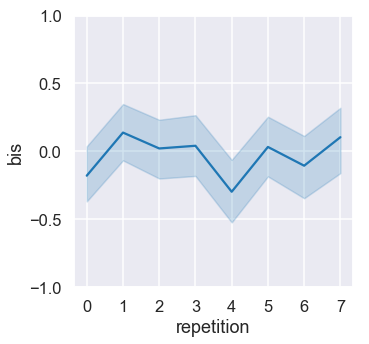

In [15]:
## visualize BIS x repetition
fig = plt.figure(figsize=(5,5))
sns.lineplot(data=X4,x='repetition',y='bis')
plt.ylim(-1,1)
t = plt.yticks(np.arange(-1, 1.1, 0.5))
t = plt.xticks(np.arange(0, 8, 1))

#### for use while running experiment to check on final scores of individual participants

In [16]:
## get final score for particular worker
w = top_workers[0]
coll.find_one({ '$and': [{'iterationName':iterationName}, \
                        {'workerId': w}]}, \
                        sort=[("score", -1)])["score"]

0.11499999999999999